In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./megadata"))

['test1', 'train']


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir("./megadata/train")
categories = []
for filename in filenames:
    category = filename.split(' ')[0]
    if category == 'cat':
        categories.append(0)
    elif category == 'cow':
        categories.append(1)
    elif category == 'dog':
        categories.append(2)
    elif category == 'elephant':
        categories.append(3)
    elif category == 'squirrel':
        categories.append(4)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,cat (1).jpeg,0
1,cat (1).jpg,0
2,cat (1).png,0
3,cat (10).jpeg,0
4,cat (10).jpg,0


In [5]:
df.loc[2000:2005]

,filename,category
2000,cow (2198).jpeg,1
2001,cow (2199).jpeg,1
2002,cow (2200).jpeg,1
2003,cow (2201).jpeg,1
2004,cow (2202).jpeg,1
2005,cow (2203).jpeg,1


In [6]:
df.loc[4000:4005]

,filename,category
4000,dog (1418).jpeg,2
4001,dog (1419).jpeg,2
4002,dog (142).jpeg,2
4003,dog (1420).jpeg,2
4004,dog (1421).jpeg,2
4005,dog (1422).jpeg,2


In [7]:
df.loc[8400:8405]

,filename,category
8400,elephant (10).jpeg,3
8401,elephant (10).jpg,3
8402,elephant (100).jpeg,3
8403,elephant (100).jpg,3
8404,elephant (1000).jpeg,3
8405,elephant (1001).jpeg,3


In [8]:
df.tail()

,filename,category
11700,squirrel (995).jpeg,4
11701,squirrel (996).jpeg,4
11702,squirrel (997).jpeg,4
11703,squirrel (998).jpeg,4
11704,squirrel (999).jpeg,4


<AxesSubplot:>

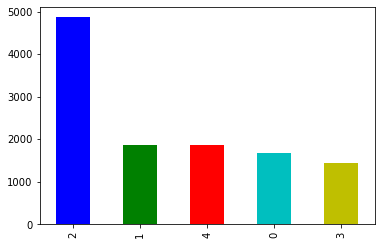

In [9]:
df['category'].value_counts().plot.bar(color=['b', 'g', 'r', 'c', 'y'])

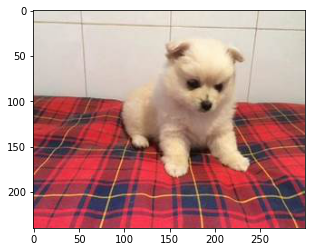

In [10]:
sample = random.choice(filenames)
image = load_img("./megadata/train/"+sample)
plt.imshow(image)

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [13]:
earlystop = EarlyStopping(patience=10)

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
callbacks = [earlystop, learning_rate_reduction]

In [16]:
df["category"] = df["category"].replace({0: 'cat', 1: 'cow', 2: 'dog', 3: 'elephant', 4: 'squirrel'}) 

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

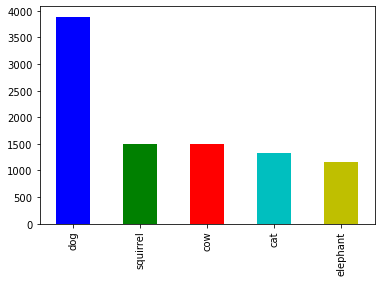

In [18]:
train_df['category'].value_counts().plot.bar(color=['b', 'g', 'r', 'c', 'y'])

<AxesSubplot:>

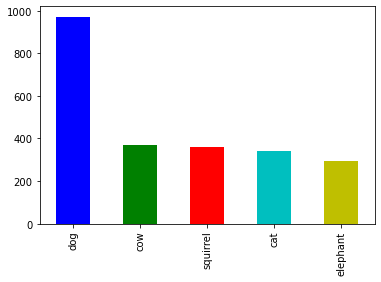

In [19]:
validate_df['category'].value_counts().plot.bar(color=['b', 'g', 'r', 'c', 'y'])

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./megadata/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 9364 validated image filenames belonging to 5 classes.


In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./megadata/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2341 validated image filenames belonging to 5 classes.


In [23]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./megadata/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


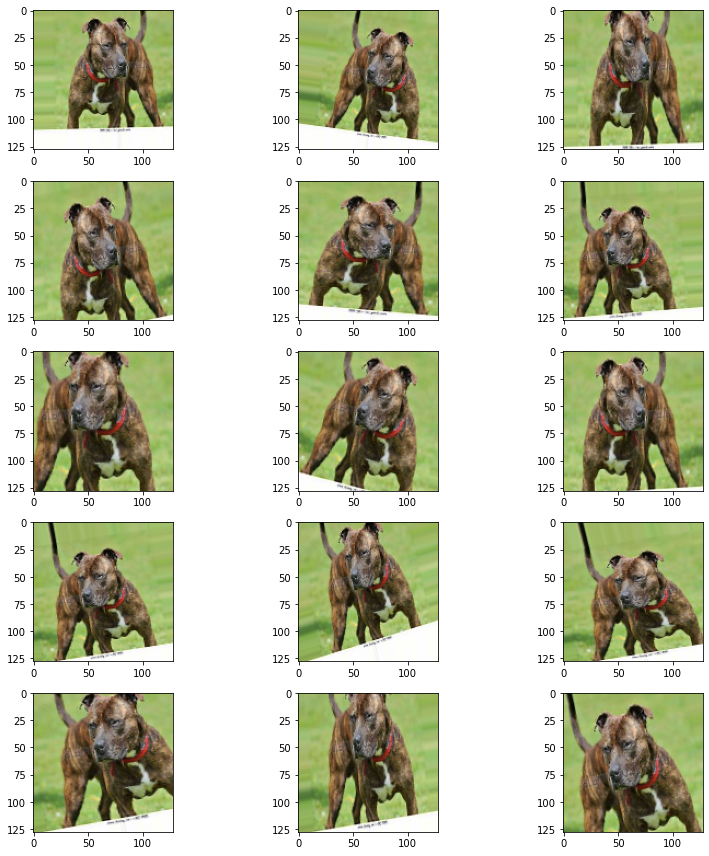

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [25]:
epochs=3 if FAST_RUN else 25
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-25-7cec04d160d1>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
624/624 [==============================] - 169s 269ms/step - loss: 1.7657 - accuracy: 0.4077 - val_loss: 1.4713 - val_accuracy: 0.4231 - lr: 0.0010
Epoch 2/25
624/624 [==============================] - 166s 266ms/step - loss: 1.2570 - accuracy: 0.5172 - val_loss: 1.3235 - val_accuracy: 0.5068 - lr: 0.0010
Epoch 3/25
624/624 [==============================] - 167s 267ms/step - loss: 1.0997 - accuracy: 0.5782 - val_loss: 1.3146 - val_accuracy: 0.5034 - lr: 0.0010
Epoch 4/25
624/624 [==============================] - ETA: 0s - loss: 1.0301 - accuracy: 0.6013
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
624/624 [==============================] - 166s 266ms/step - loss: 1.0301 - accuracy: 0.6013 - val_loss: 1.2909 - val_accuracy: 0.4889 - lr: 0.0010
Epoch 5/25
624/624 [==============================] - 166s 266ms/step - loss: 0.9185 - accuracy: 0.6491 - val_loss: 1.1719 - val_accuracy: 0.5962 - lr: 5.0000e-04
Epoch 6/25
624/624 [================

In [26]:
model.save_weights("model.h5")

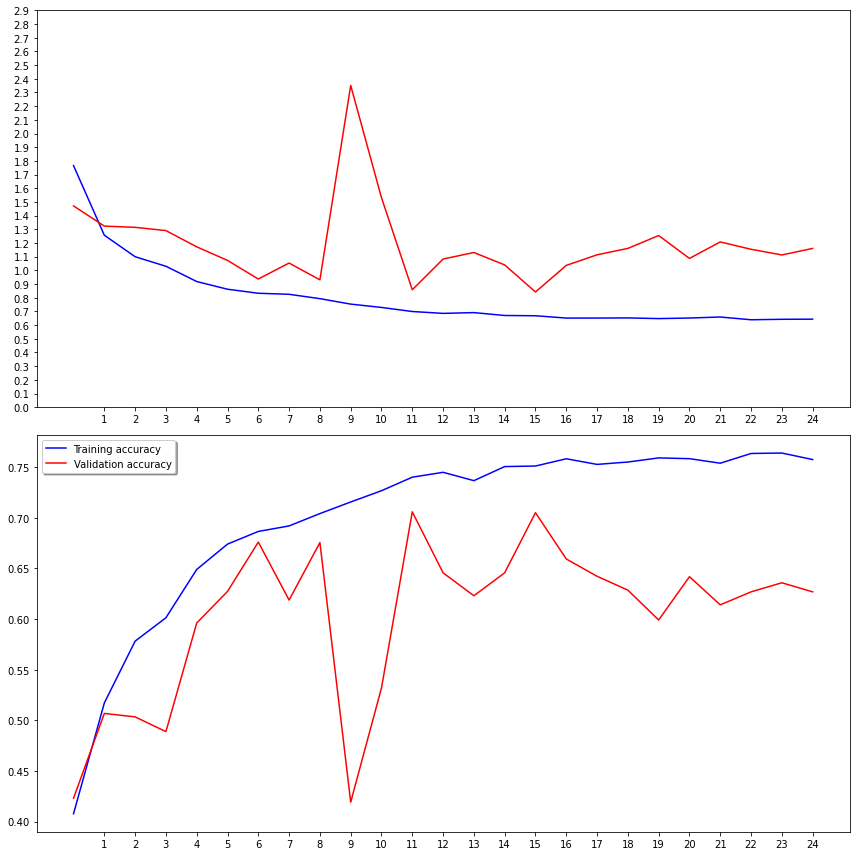

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 3, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [28]:
test_filenames = os.listdir("./megadata/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [29]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./megadata/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [30]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-30-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [31]:
test_df['category'] = np.argmax(predict, axis=-1)

In [32]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [33]:
test_df['category'] = test_df['category'].replace({0: 'cat', 1: 'cow', 2: 'dog', 3: 'elephant', 4: 'squirrel'})

<AxesSubplot:>

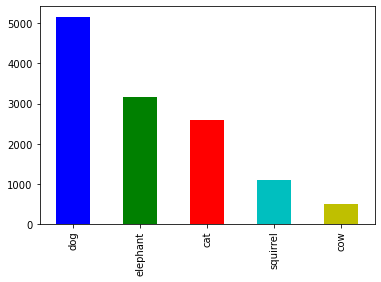

In [34]:
test_df['category'].value_counts().plot.bar(color=['b', 'g', 'r', 'c', 'y'])

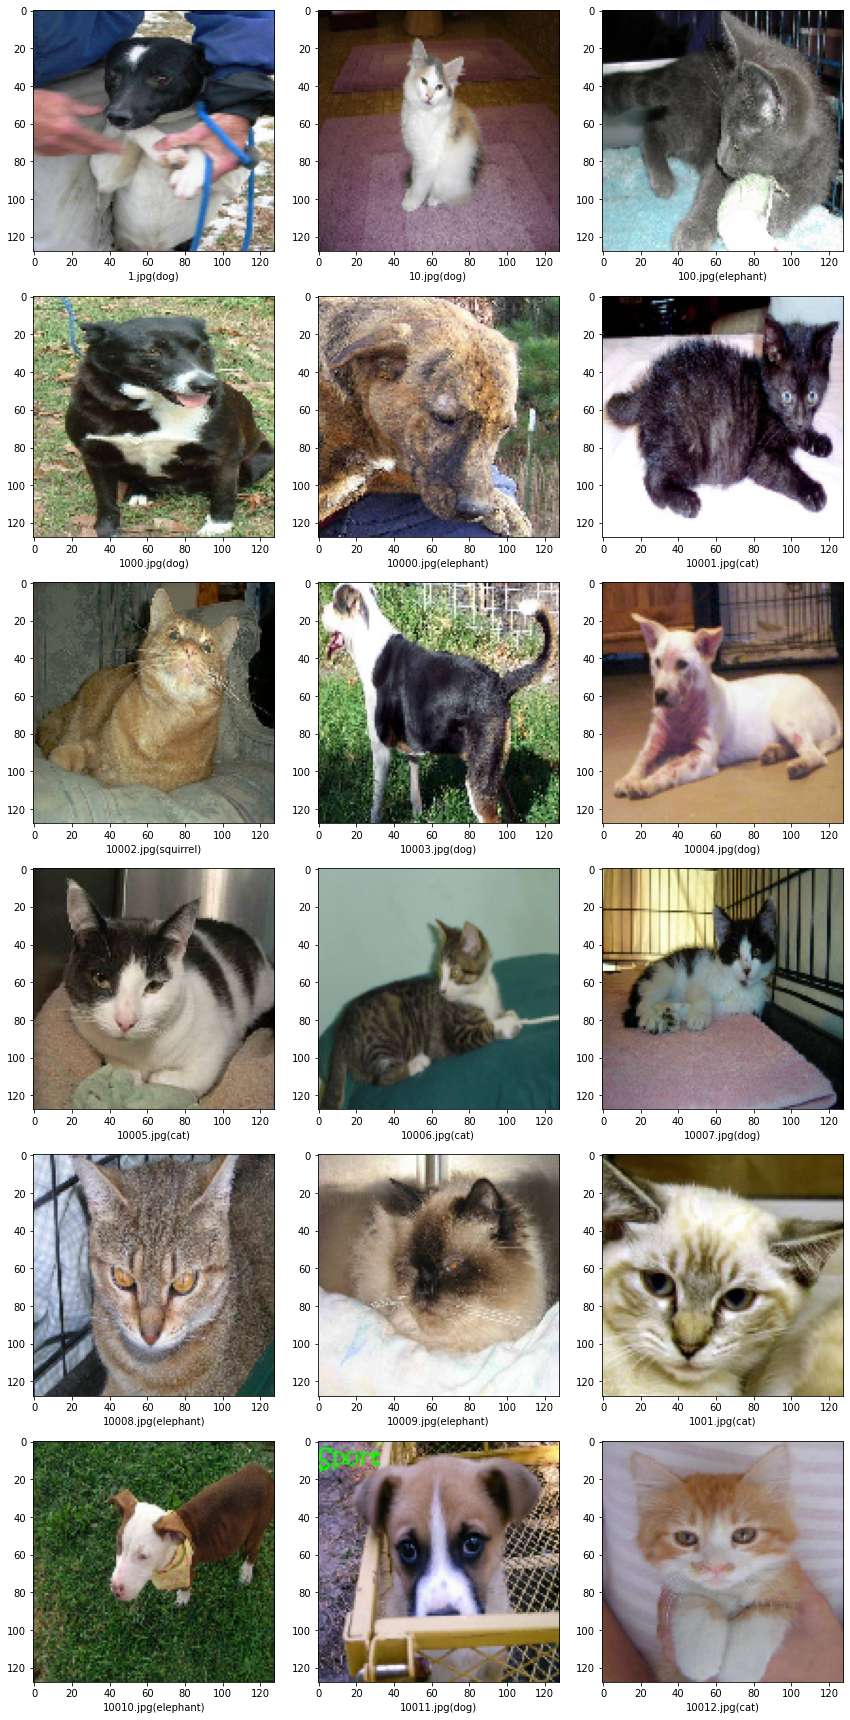

In [35]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./megadata/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()